In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


# Download training data from MNIST datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64

# Create data loaders to iterate over data
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print("Training data size:", len(train_dataloader)* batch_size)
print("Test data size:", len(test_dataloader) * batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


100%|██████████| 9912422/9912422 [00:00<00:00, 83834506.04it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9891050.37it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 19573129.82it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3959785.65it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Training data size: 60032
Test data size: 10048
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [ ]:

from data import *
device = torch.device("cuda" if torch.cuda.is_available()
else "mps" if torch.backends.mps.is_available()
else "cpu")

print(f"Using {device} device")

#Define model
class NeuralNetwork(nn.Module):
       def __init__(self, input_size, hidden_size, num_classes):
             super().__init__()
             self.flatten = nn.Flatten()
             self.linear_relu_stack = nn.Sequential(nn.Linear(input_size, hidden_size),
                                                     nn.ReLU(),
                                             nn.Linear(hidden_size, hidden_size),
                                                nn.ReLU(),
                                             nn.Linear(hidden_size, num_classes))
       def forward(self, image_tensor):
        image_tensor = self.flatten(image_tensor)
        logits = self.linear_relu_stack(image_tensor)
        return logits
input_size = 28*28
hidden_size = 512
num_classes = 10

model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)
print(model)


Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
# Define our learning rate, loss function and optimizer
learning_rate = 1e-3 # 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Let's define our training function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    print(size)

    for batch_num, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)


        # Forward pass to compute prediction
        pred = model(X)
        # Compute prediction error using loss function
        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad() # zero any previous gradient calculations
        loss.backward() # calculate gradient
        optimizer.step() # update model parameters


        if batch_num > 0 and batch_num % 100 == 0:

            loss, current = loss.item(), batch_num * len(X)

            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
# Our test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)

    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
# Let's run training
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
60000
loss: 0.268714  [ 6400/60000]
loss: 0.200253  [12800/60000]
loss: 0.242973  [19200/60000]
loss: 0.142733  [25600/60000]
loss: 0.342634  [32000/60000]
loss: 0.128765  [38400/60000]
loss: 0.234448  [44800/60000]
loss: 0.238469  [51200/60000]
loss: 0.161584  [57600/60000]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.145716 

Epoch 2
-------------------------------
60000
loss: 0.094390  [ 6400/60000]
loss: 0.149229  [12800/60000]
loss: 0.091209  [19200/60000]
loss: 0.049177  [25600/60000]
loss: 0.135029  [32000/60000]
loss: 0.046671  [38400/60000]
loss: 0.125195  [44800/60000]
loss: 0.149340  [51200/60000]
loss: 0.097758  [57600/60000]
Test Error: 
 Accuracy: 97.0%, Avg loss: 0.096799 

Epoch 3
-------------------------------
60000
loss: 0.053332  [ 6400/60000]
loss: 0.064790  [12800/60000]
loss: 0.060549  [19200/60000]
loss: 0.024525  [25600/60000]
loss: 0.049589  [32000/60000]
loss: 0.032454  [38400/60000]
loss: 0.072347  [44800/60000]
loss: 0.

In [ ]:
# Save our model parameters
torch.save(model.state_dict(), "ml_with_pytorch_model.pth")
print("Saved PyTorch Model State to ml_with_pytorch_model.pth")

# Load the saved model parameters into a new instance of the model
model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)
model.load_state_dict(torch.load("ml_with_pytorch_model.pth"))

# Inference using the new model instance
model.eval()
for i in range(10):
    x, y = test_data[i][0], test_data[i][1]

    x = x.to(device)
    pred = model(x)
    predicted, actual = pred[0].argmax(0).item(), y
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Saved PyTorch Model State to ml_with_pytorch_model.pth
Predicted: "7", Actual: "7"
Predicted: "2", Actual: "2"
Predicted: "1", Actual: "1"
Predicted: "0", Actual: "0"
Predicted: "4", Actual: "4"
Predicted: "1", Actual: "1"
Predicted: "4", Actual: "4"
Predicted: "9", Actual: "9"
Predicted: "5", Actual: "5"
Predicted: "9", Actual: "9"


FGSM ATTACK

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "/content/lenet_mnist_model.pth"
use_cuda=True
# Set random seed for reproducibility
torch.manual_seed(42)

In [ ]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location=device))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [ ]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9912 / 10000 = 0.9912
Epsilon: 0.05	Test Accuracy = 9605 / 10000 = 0.9605
Epsilon: 0.1	Test Accuracy = 8743 / 10000 = 0.8743
Epsilon: 0.15	Test Accuracy = 7111 / 10000 = 0.7111
Epsilon: 0.2	Test Accuracy = 4877 / 10000 = 0.4877
Epsilon: 0.25	Test Accuracy = 2717 / 10000 = 0.2717
Epsilon: 0.3	Test Accuracy = 1418 / 10000 = 0.1418


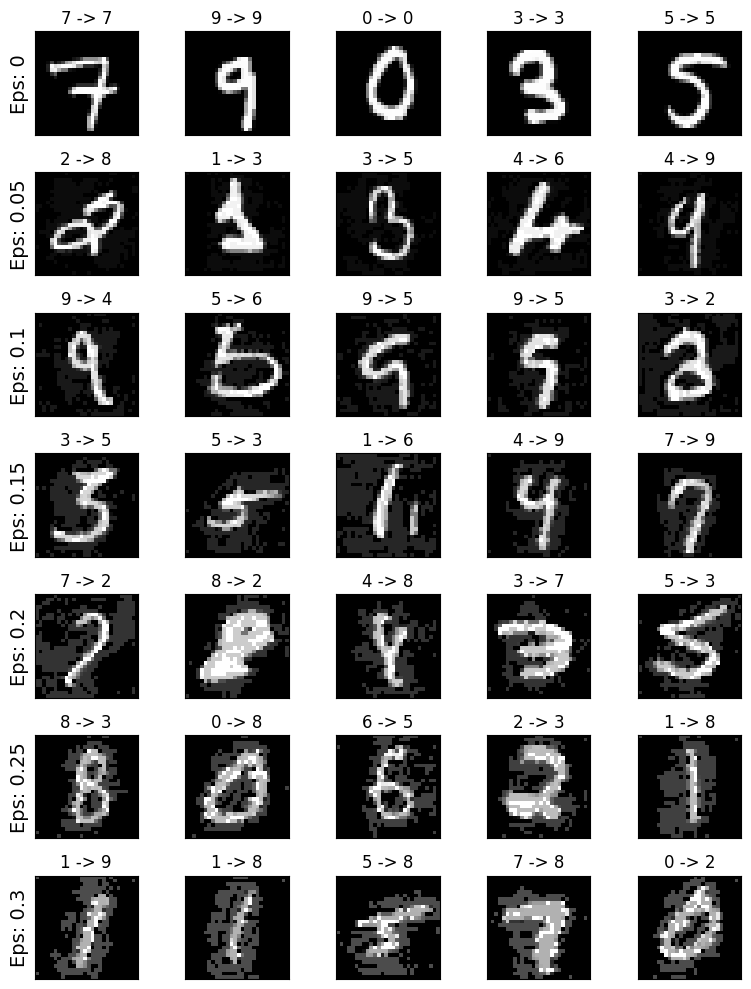

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

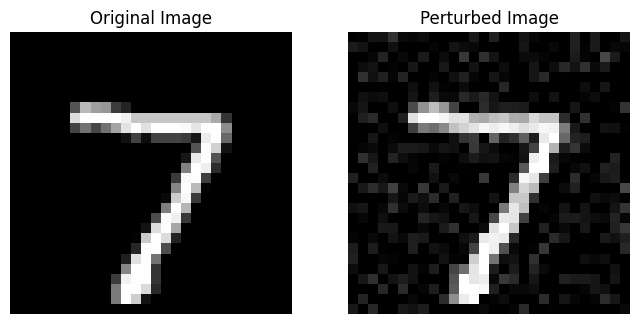

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Choose an image from the dataset
image_index = 0
original_image = x_test[image_index]



# Generate perturbation (adding random noise)
perturbation = np.random.normal(loc=0, scale=25, size=original_image.shape)

# Add perturbation to the original image
perturbed_image = original_image + perturbation

# Clip values to ensure they are within the valid range [0, 255]
perturbed_image = np.clip(perturbed_image, 0, 255)




# Plot original and perturbed images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(perturbed_image, cmap='gray')
plt.title('Perturbed Image')
plt.axis('off')
plt.savefig("perturbed_image.png")
plt.show()


In [ ]:
#Train and save FC-512-512 MODEL

# Let's run training
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)

print("Done!")


Epoch 1
-------------------------------
60000
loss: 0.247984  [ 6400/60000]
loss: 0.190830  [12800/60000]
loss: 0.240079  [19200/60000]
loss: 0.138697  [25600/60000]
loss: 0.328954  [32000/60000]
loss: 0.137062  [38400/60000]
loss: 0.253609  [44800/60000]
loss: 0.342759  [51200/60000]
loss: 0.172728  [57600/60000]
Epoch 2
-------------------------------
60000
loss: 0.114006  [ 6400/60000]
loss: 0.094374  [12800/60000]
loss: 0.099795  [19200/60000]
loss: 0.041827  [25600/60000]
loss: 0.098348  [32000/60000]
loss: 0.054462  [38400/60000]
loss: 0.149452  [44800/60000]
loss: 0.133910  [51200/60000]
loss: 0.116361  [57600/60000]
Epoch 3
-------------------------------
60000
loss: 0.062209  [ 6400/60000]
loss: 0.044581  [12800/60000]
loss: 0.094021  [19200/60000]
loss: 0.042418  [25600/60000]
loss: 0.054065  [32000/60000]
loss: 0.046945  [38400/60000]
loss: 0.043699  [44800/60000]
loss: 0.138425  [51200/60000]
loss: 0.065454  [57600/60000]
Epoch 4
-------------------------------
60000
loss: 